# マルチカーペイントショップ問題

マルチカーペイントショップ問題（以下、MCPS問題）とは、工場で複数の車種を塗装する際の塗料の切り替え回数を最小化する問題です。本チュートリアルでは、マルチカーペイントショップ問題をどのように解くかを説明します。

## 問題設定

塗装工程では、顧客の要望によって色が決めるベースコートとその下に塗られるフィラーコートという作業が存在します。フィラーコートで使用される塗料の色はベースコートで使用される塗料の色によって決まり、ベースコートの色が濃い場合は黒色が、ベースコートの色が薄い場合は白色が使用されます。MCPS問題は、このフィラーコートの色の切り替え回数を最小化する問題です。

まずは、具体的に考えてみましょう。簡単のために、2つの車種 $C_1, C_2$ だけのケースを考えます。塗装待ちの列に $C_1, C_1, C_2, C_2, C_1, C_2$ の順番で6台の車が入ってきたとします。車種 $C_l$ に対してフィラーコートを黒く塗る台数を $k(C_l) \ (l=1, 2)$ とし、 $k(C_l)=2, k(C_2)=1$ の場合を考えてみましょう。すなわち、フィラーコート作業で車種1を2台、車種2を1台、黒色に塗る必要がある場合です。この場合、黒で塗る車を $B$ 、白で塗る車を $W$ と書くことにすると、フィラーコートの塗料の切り替え回数が最小になるのは、塗装待ちの列に対して $B, B, B, W, W, W$ になります。

## 定式化

以下では、車種の数が $n$で、塗装待ちの列に $N$ 台の車が入っている場合を考えます。

### 決定変数

まず、MCPS問題の決定変数として以下のようなバイナリ変数を定義します。

$$
q_{i} = \begin{cases}
1~\text{($i$ 番目の車を黒で塗る場合)}\\
0~\text{(それ以外)}\\
\end{cases}
$$

$$
i \in \{0, ..., N-1\}
$$

### 制約

MCPS問題の制約として次のようなものが考えられます。

- 車種 $C_l$ のうち、フィラーコートで黒く塗られた車の数は $k(C_l)$ に等しくなければならない

この制約は、車種 $C_l$ に対する $k(C_l)$ -hot 制約として定式化することができます。すなわち、以下のように定式化できます。

$$
\sum_{i\in C_l} q_i = k(C_l) \ \forall\ l
$$

### 目的関数

MCPS問題の目的は、フィラーコート作業における塗料の切り替え回数を最小化することです。この目的を言い換えると、連続する車へ塗る塗料の色をなるべく同じにすることだと言えます。連続する車が同じ色で塗られることは、イジングモデルの強磁性定式化に倣って、次のように定式化することができます。

$$
H_A = -\sum_{i=0}^{N-2}s_is_{i+1}.
$$

ここで $s_i \in \{-1, 1\}$ はスピン変数です。スピン変数とバイナリ変数の間には相互変換可能な関係があり、スピン変数をバイナリ変数に直すには、 $s_i = 2q_i -1$ という代入を行えば良いです。よって、上の定式化は以下のようにバイナリ変数のみの定式化に書き換えることができます。

$$
H_A = -\sum_{i=0}^{N-2}s_is_{i+1} = -\sum_{i=0}^{N-2}(2q_i - 1)(2q_{i+1} - 1)
$$

これらの制約と目的関数をまとめることで、MCPS問題は以下のように定式化することができます。

$$
\begin{aligned}
&\text{Minimize}\quad H_A = -\sum_{i=0}^{N-2}(2q_i - 1)(2q_{i+1} - 1) \\
&\text{subject to } \sum_{i\in C_l} q_i = k(C_l)　\forall\  l
\end{aligned}
$$

## JijModelingによる定式化

次に、JijModelingを使って上記の数理モデルを実装してみましょう。まずは、数理モデルに現れる変数およびパラメーターを定義します。

In [1]:
import jijmodeling as jm

N = jm.Placeholder("N") # Number of cars
n = jm.Placeholder("n") # Number of car models
C = jm.Placeholder("C", ndim=2) # indices of each car models
K = jm.Placeholder("K", ndim=1) # Number of black cars for each car models

q = jm.BinaryVar("q", shape=(N,))

l = jm.Element("l", belong_to=(0,n))
i = jm.Element("i", belong_to=C[l]) 
j = jm.Element("j", belong_to=(0,N-1))

ここで車種 $C_l$ は以下のような形のデータで格納されることを想定しています。

```python
[[0, 3, 8, 10], [1, 4, 6, 9, 12], [2, 5, 7, 11, 13]] 
```

例えば、上のデータであれば、車種 $C_0$ の車は `0`, `3`, `8`, `10` で、車種 $C_1$ の車は `1`, `4`, `6`, `9`, `12`、車種 $C_2$ の車は `2`, `5`, `7`, `11`, `13` です。JijModelingは、このような形のデータを2次元の `Placeholder` として格納することができます。

定義した変数およびパラメーターを用いて、MCPS問題を表す数理モデルを定式化しましょう。

In [2]:
problem = jm.Problem("multi car paint")

problem += jm.Constraint("K_l-hot constraint", jm.sum(i,q[i]) == K[l], forall=l)
problem += -jm.sum(j,(2*q[j] - 1)*(2*q[j+1] - 1))
problem

## インスタンスデータの準備

以下では、車の台数を30台、車種の数を4種類とするランダムなインスタンスデータを準備します。次のコードでそのようなインスタンスデータを生成することができます。

In [3]:
import numpy as np

num_carmodels = 4
num_cars = 30
sequence = np.random.choice(range(num_carmodels), num_cars)
carmodels_list = [[] for i in range(num_carmodels)]
for index,car_index in enumerate(sequence):
    carmodels_list[car_index].append(index)

In [4]:
num_blackcar = [int(np.ceil(len(cars)/2)) for cars in carmodels_list]
instance_data = {"N": num_cars, "n": num_carmodels, "K": num_blackcar, "C": carmodels_list}

In [5]:
instance_data

{'N': 30,
 'n': 4,
 'K': [3, 4, 3, 6],
 'C': [[2, 3, 17, 18, 25, 26],
  [7, 9, 10, 15, 20, 22, 27],
  [1, 6, 16, 21, 23, 29],
  [0, 4, 5, 8, 11, 12, 13, 14, 19, 24, 28]]}

## MCPS問題を解く

このMCPS問題を、`jijsolver`を用いて解きましょう。

In [6]:
import jijsolver 

interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)

## 解の確認

得られた解がどのようになっているのか確認してみましょう。 `ommx.v1.Solution` の `decision_variables` プロパティにアクセスすることで確認できます。

In [7]:
df = solution.decision_variables
df

kind  lower  upper name subscripts description substituted_value  value
id                                                                           
0   binary    0.0    1.0    q        [0]        <NA>              <NA>    1.0
1   binary    0.0    1.0    q        [1]        <NA>              <NA>    1.0
2   binary    0.0    1.0    q        [2]        <NA>              <NA>    1.0
3   binary    0.0    1.0    q        [3]        <NA>              <NA>    1.0
4   binary    0.0    1.0    q        [4]        <NA>              <NA>    1.0
5   binary    0.0    1.0    q        [5]        <NA>              <NA>    1.0
6   binary    0.0    1.0    q        [6]        <NA>              <NA>    1.0
7   binary    0.0    1.0    q        [7]        <NA>              <NA>    1.0
8   binary    0.0    1.0    q        [8]        <NA>              <NA>    1.0
9   binary    0.0    1.0    q        [9]        <NA>              <NA>    1.0
10  binary    0.0    1.0    q       [10]        <NA>              <NA>    1.0
11  binary    0.0    1.0    q       [11]        <NA>              <NA>    1.0
12  binary    0.0    1.0    q       [12]        <NA>              <NA>    0.0
13  binary    0.0    1.0    q       [13]        <NA>              <NA>    0.0
14  binary    0.0    1.0    q       [14]        <NA>              <NA>    0.0
15  binary    0.0    1.0    q       [15]        <NA>              <NA>    0.0
16  binary    0.0    1.0    q       [16]        <NA>              <NA>    0.0
17  binary    0.0    1.0    q       [17]        <NA>              <NA>    0.0
18  binary    0.0    1.0    q       [18]        <NA>              <NA>    0.0
19  binary    0.0    1.0    q       [19]        <NA>              <NA>    0.0
20  binary    0.0    1.0    q       [20]        <NA>              <NA>    0.0
21  binary    0.0    1.0    q       [21]        <NA>              <NA>    0.0
22  binary    0.0    1.0    q       [22]        <NA>              <NA>    0.0
23  binary    0.0    1.0    q       [23]        <NA>              <NA>    0.0
24  binary    0.0    1.0    q       [24]        <NA>              <NA>    0.0
25  binary    0.0    1.0    q       [25]        <NA>              <NA>    0.0
26  binary    0.0    1.0    q       [26]        <NA>              <NA>    1.0
27  binary    0.0    1.0    q       [27]        <NA>              <NA>    1.0
28  binary    0.0    1.0    q       [28]        <NA>              <NA>    1.0
29  binary    0.0    1.0    q       [29]        <NA>              <NA>    1.0

## 解の可視化

最後に、今回の問題に対してどのようにフィラーコートの塗り分けを行えば良いのかを確認してみましょう。以下のコードを実行することで塗り分け方の可視化をすることができます。

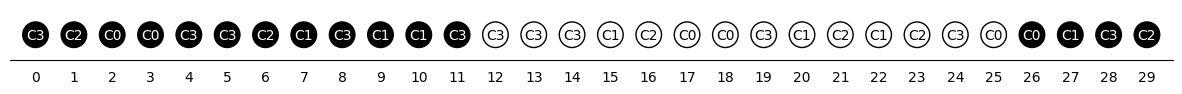

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

solution = df["value"].to_list()
fig, ax = plt.subplots(figsize=(15,8))
ax.tick_params(labelleft=False,left=False,bottom=False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

for i in range(num_cars):
    position = (1.5*i, 0)
    circ = patches.Circle(xy=position, radius=0.5, fc= "k" if solution[i] else "w", ec="k")
    c_txt = plt.text(*position, "C%s"%(sequence[i]), color = "w" if solution[i] else "k", horizontalalignment="center", verticalalignment="center")
    ax.add_patch(circ)
ax.set_xticks(np.arange(num_cars)*1.5, np.arange(num_cars),fontsize=10)   
ax.set_xlim(-1, 1.5*num_cars-0.5)
ax.set_ylim(-1, 1)
ax.set_aspect("equal")
plt.show()

## 参考文献

[1] Sheir Yarkoni, et al., "[Multi-car paint shop optimization with quantum annealing](https://arxiv.org/abs/2109.07876)" (2019)